# Performance Study for the ART Network

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas
from sklearn.externals import joblib
# Network import: should be in the path if framework configured correctly
import neuralnet as nn
import PyNN.NeuralNet as PyNNet
import PyNN.TrnInfo as PyTrnInfo
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import scipy as sc

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']
markers= ['o','x','^','d']

import matplotlib as mpl
#mpl.style.use('bmh')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1



classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
sonarhome = os.getenv('SONARHOME')
sonarnov = os.getenv('SONARNOVELTY')
nfft = 1024

npcd = 40

## Load Data

In [2]:
data = {}
target = {}
data_nov = {}
cvPar = {}
nov_det_classes = {}
for nov in noveltyclasses:
    fdata = sonarhome + '/data/novelty_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fdata)
    data[nov] = obj['data']
    data_nov[nov] = obj['data_nov']
    target[nov] = obj['target']
    cvPar[nov] = obj['cvPar']
    nov_det_classes[nov] = obj['classes']
nPts = data[nov].shape[1]

# Load PCD 

In [3]:
pcdnet = {}
for nov in noveltyclasses:
    pcdnet[nov] = {}
    # Deflation (or independent)
    filepcd = sonarnov + '/PCD/Deflation/pcddef_' + nov + '_' + str(nfft) + 'nfft.jbl'
    pcdnet[nov]['def'] = joblib.load(filepcd)
    # Cooperative (or constructive)
    filepcd = sonarnov + '/PCD/Constructive/pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    pcdnet[nov]['coo'] = joblib.load(filepcd)

# Simulate ART

In [4]:
npcd = 30

In [36]:
mlp_out = {}
mlp_out_nov = {}
for novcls in noveltyclasses:
    print 'Novelty: ', novcls
    mlp_out[novcls] = {}
    mlp_out_nov[novcls] = {}
    NCV = cvPar[novcls]['CVNSel']
    for typ in ('coo','def'):
        mlp_out[novcls][typ] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
        mlp_out_nov[novcls][typ] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
    # Over CV
    for icv in range(NCV):
        # Deflation
        W = pcdnet[novcls]['def']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
        nnet = pcdnet[novcls]['def']['Classifier'].results[icv][npcd].nnets[npcd]
        mlp_out[novcls]['def'][icv]     = nnet.feedforward(W.dot(data[novcls].transpose()).transpose())
        mlp_out_nov[novcls]['def'][icv] = nnet.feedforward(W.dot(data_nov[novcls].transpose()).transpose())
        # Cooperative
        nnet = pcdnet[novcls]['coo']['PCDModel'].results[icv].PCDNets[npcd-1]
        mlp_out[novcls]['coo'][icv] = nnet.feedforward(data[novcls])
        mlp_out_nov[novcls]['coo'][icv] = nnet.feedforward(data_nov[novcls])
        

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


## MLP - Performance

### Cooperative

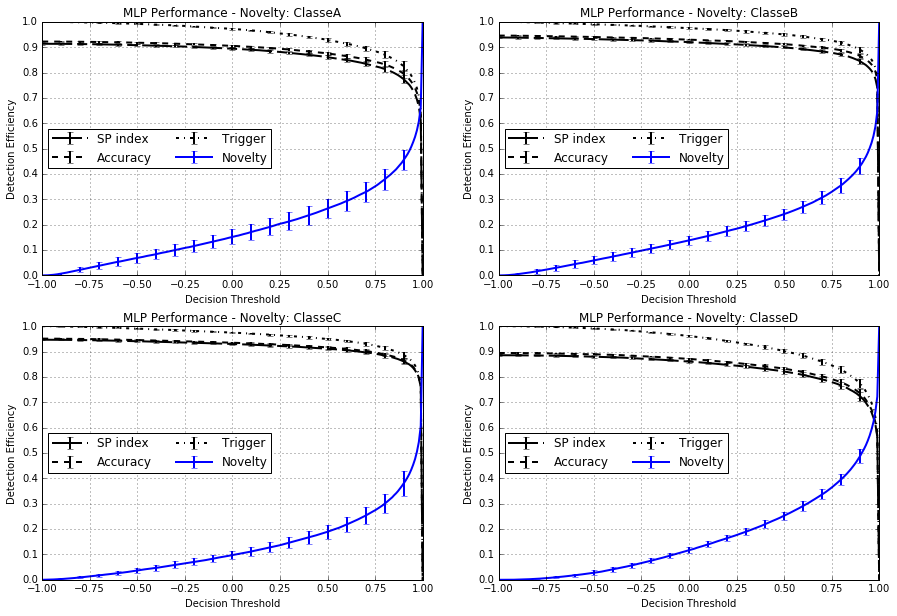

In [40]:
plt.figure(figsize=(15,10), facecolor='w')
mlp_thrs = np.arange(-1,1.01,0.01)
# LOOP OVER NOVELTIES
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    pcdtype = 'coo'
    NCV = cvPar[novcls]['CVNSel']
    T = np.argmax(target[novcls], axis=1)
    tgt_classes = np.unique(T)
    nclasses = tgt_classes.shape[0]

    novelty  = np.zeros((NCV, len(mlp_thrs)))*np.nan  # novely efficiency
    accuracy = np.zeros((NCV, len(mlp_thrs)))  # Total accuracy
    trigger = np.zeros((NCV, len(mlp_thrs)))  # Sytem trigger
    effclass = np.zeros((tgt_classes.shape[0], NCV, len(mlp_thrs))) # Accuracy per class

    # LOOP OVER CV
    for icv in range(NCV):
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        # TEST NOVELTY
        Yhat = np.max(mlp_out_nov[novcls][pcdtype][icv], axis=1)
        for ith, th in enumerate(mlp_thrs):
            novelty[icv, ith] = (Yhat < th).sum() / float(Yhat.shape[0])
        # CLASS EFFICIENCY
        for icls, cls in enumerate(tgt_classes):
            # Filter class
            itgt = T == cls
            idx = np.intersect1d(itst, np.nonzero(itgt)[0])
            Yhat = mlp_out[novcls][pcdtype][icv]
            for ith, th in enumerate(mlp_thrs):
                Ycls = np.argmax(Yhat, axis=1)
                Ymax = np.max(Yhat, axis=1)
                effclass[icls, icv, ith] = ((Ycls[idx] == cls) & (Ymax[idx] >= th)).sum() / float(idx.shape[0])
                accuracy[icv, ith] = accuracy[icv, ith] + ((Ycls[idx] == cls) & (Ymax[idx] >= th)).sum()
                trigger[icv, ith] = trigger[icv, ith] + (Ymax[idx] >= th).sum()            
        accuracy[icv] = accuracy[icv] / float(len(itst))
        trigger[icv]  = trigger[icv]  / float(len(itst))   
    # PLOT SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/nclasses) * np.mean(effclass, axis=0))
    plt.errorbar(mlp_thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=10, label='SP index')
    # PLOT ACCURACY
    plt.errorbar(mlp_thrs, np.mean(accuracy, axis=0), np.std(accuracy, axis=0), fmt='--k',
                 errorevery=10, label='Accuracy')
    # PLOT SYSTEM TRIGGER
    plt.errorbar(mlp_thrs, np.mean(trigger, axis=0), np.std(trigger, axis=0), fmt='-.k',
                 errorevery=10, label='Trigger')
    # PLOT NOVELTY DETECTION
    h= plt.errorbar(mlp_thrs, np.mean(novelty, axis=0), np.std(novelty, axis=0), fmt='-b',
                    errorevery=10, label='Novelty')
    plt.title('MLP Performance - Novelty: ' + novcls)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Detection Efficiency')
    plt.xlim((-1,1))
    plt.ylim([0,1])
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(-1,1.25,0.25))
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.legend(loc='best', ncol=2)
    plt.grid(True)
    #plt.tight_layout()

### Deflation

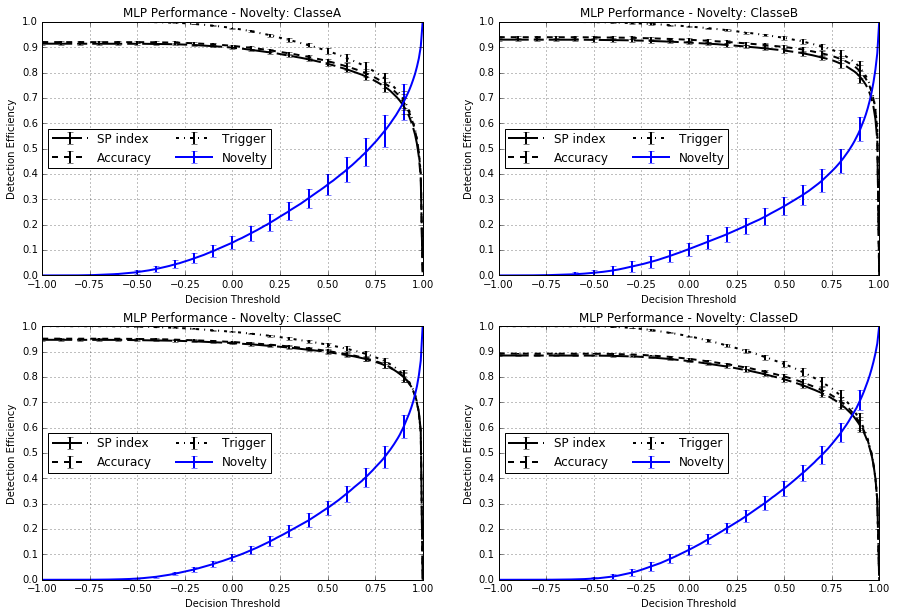

In [41]:
plt.figure(figsize=(15,10), facecolor='w')
mlp_thrs = np.arange(-1,1.01,0.01)
# LOOP OVER NOVELTIES
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    pcdtype = 'def'
    NCV = cvPar[novcls]['CVNSel']
    T = np.argmax(target[novcls], axis=1)
    tgt_classes = np.unique(T)
    nclasses = tgt_classes.shape[0]

    novelty  = np.zeros((NCV, len(mlp_thrs)))*np.nan  # novely efficiency
    accuracy = np.zeros((NCV, len(mlp_thrs)))  # Total accuracy
    trigger = np.zeros((NCV, len(mlp_thrs)))  # Sytem trigger
    effclass = np.zeros((tgt_classes.shape[0], NCV, len(mlp_thrs))) # Accuracy per class

    # LOOP OVER CV
    for icv in range(NCV):
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        # TEST NOVELTY
        Yhat = np.max(mlp_out_nov[novcls][pcdtype][icv], axis=1)
        for ith, th in enumerate(mlp_thrs):
            novelty[icv, ith] = (Yhat < th).sum() / float(Yhat.shape[0])
        # CLASS EFFICIENCY
        for icls, cls in enumerate(tgt_classes):
            # Filter class
            itgt = T == cls
            idx = np.intersect1d(itst, np.nonzero(itgt)[0])
            Yhat = mlp_out[novcls][pcdtype][icv]
            for ith, th in enumerate(mlp_thrs):
                Ycls = np.argmax(Yhat, axis=1)
                Ymax = np.max(Yhat, axis=1)
                effclass[icls, icv, ith] = ((Ycls[idx] == cls) & (Ymax[idx] >= th)).sum() / float(idx.shape[0])
                accuracy[icv, ith] = accuracy[icv, ith] + ((Ycls[idx] == cls) & (Ymax[idx] >= th)).sum()
                trigger[icv, ith] = trigger[icv, ith] + (Ymax[idx] >= th).sum()            
        accuracy[icv] = accuracy[icv] / float(len(itst))
        trigger[icv]  = trigger[icv]  / float(len(itst))   
    # PLOT SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/nclasses) * np.mean(effclass, axis=0))
    plt.errorbar(mlp_thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=10, label='SP index')
    # PLOT ACCURACY
    plt.errorbar(mlp_thrs, np.mean(accuracy, axis=0), np.std(accuracy, axis=0), fmt='--k',
                 errorevery=10, label='Accuracy')
    # PLOT SYSTEM TRIGGER
    plt.errorbar(mlp_thrs, np.mean(trigger, axis=0), np.std(trigger, axis=0), fmt='-.k',
                 errorevery=10, label='Trigger')
    # PLOT NOVELTY DETECTION
    h= plt.errorbar(mlp_thrs, np.mean(novelty, axis=0), np.std(novelty, axis=0), fmt='-b',
                    errorevery=10, label='Novelty')
    plt.title('MLP Performance - Novelty: ' + novcls)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Detection Efficiency')
    plt.xlim((-1,1))
    plt.ylim([0,1])
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(-1,1.25,0.25))
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.legend(loc='best', ncol=2)
    plt.grid(True)
    #plt.tight_layout()

## Cooperative x Deflation

[0, 1, 0, 1]

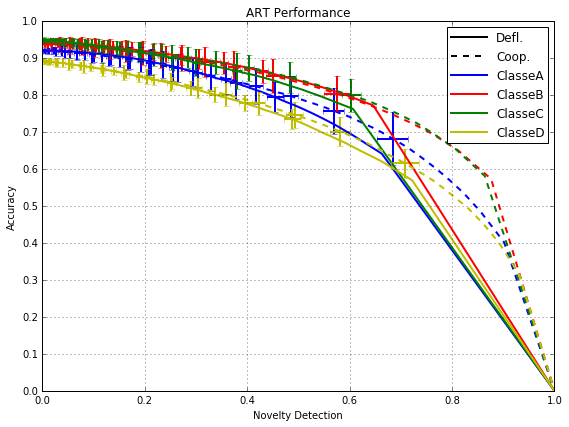

In [47]:
plt.figure(figsize=(8,6), facecolor='w')
mlp_thrs = np.arange(-1,1.01,0.01)
# LOOP OVER NOVELTIES
for inov, novcls in enumerate(noveltyclasses):
    NCV = cvPar[novcls]['CVNSel']
    T = np.argmax(target[novcls], axis=1)
    tgt_classes = np.unique(T)
    nclasses = tgt_classes.shape[0]
    novelty = {}
    accuracy = {}
    for pcdtype in ('coo','def'):
        novelty[pcdtype]  = np.zeros((NCV, len(mlp_thrs)))*np.nan  # novely efficiency
        accuracy[pcdtype] = np.zeros((NCV, len(mlp_thrs)))  # Total accuracy
        # LOOP OVER CV
        for icv in range(NCV):
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            Yhat = mlp_out_nov[novcls][pcdtype][icv]
            # TEST NOVELTY
            Yhat = np.max(mlp_out_nov[novcls][pcdtype][icv], axis=1)
            for ith, th in enumerate(mlp_thrs):
                novelty[pcdtype][icv, ith] = (Yhat < th).sum() / float(Yhat.shape[0])
            # CLASS EFFICIENCY
            for icls, cls in enumerate(tgt_classes):
                # Filter class
                itgt = T == cls
                idx = np.intersect1d(itst, np.nonzero(itgt)[0])
                Yhat = mlp_out[novcls][pcdtype][icv]
                for ith, th in enumerate(mlp_thrs):
                    Ycls = np.argmax(Yhat, axis=1)
                    Ymax = np.max(Yhat, axis=1)
                    accuracy[pcdtype][icv, ith] = accuracy[pcdtype][icv, ith] + \
                                                  ((Ycls[idx] == cls) & (Ymax[idx] >= th)).sum()
            accuracy[pcdtype][icv] = accuracy[pcdtype][icv] / float(len(itst))
    # PLOT COOPERATIVE
    icls = np.nonzero(classes == novcls)[0][0]
    hdef = plt.errorbar(np.mean(novelty['coo'], axis=0), np.mean(accuracy['coo'], axis=0),
                        np.std(novelty['coo'], axis=0),np.std(accuracy['coo'], axis=0), fmt='-',
                        color=colors[icls], errorevery=10, label=novcls + ' Coo.')
    # PLOT DEFLATION
    icls = np.nonzero(classes == novcls)[0][0]
    hcoo = plt.errorbar(np.mean(novelty['def'], axis=0), np.mean(accuracy['def'], axis=0),
                        np.std(novelty['def'], axis=0),np.std(accuracy['def'], axis=0), fmt='--',
                        color=colors[icls], errorevery=10, label=novcls + ' Def.')
# LABELS
leg_handlers = []
leg_labels = []
h = plt.plot([], [], ls='-', c='k')[0]
leg_handlers.append(h)
leg_labels.append('Defl.')
h = plt.plot([], [], ls='--', c='k')[0]
leg_handlers.append(h)
leg_labels.append('Coop.')    
for inov, novcls in enumerate(noveltyclasses):
    icls = np.nonzero(classes == novcls)[0][0]
    h = plt.plot([], [], ls='-', color=colors[icls])[0]
    leg_handlers.append(h)
    leg_labels.append(novcls)  
    
plt.title('ART Performance')
plt.xlabel('Novelty Detection')
plt.ylabel('Accuracy')
plt.gca().set_yticks(np.linspace(0,1,11))
plt.legend(leg_handlers, leg_labels, loc='best', ncol=1).get_frame().set_facecolor('1')
plt.grid(True)
plt.tight_layout()
plt.axis([0,1,0,1])